# Example full chip design

In [1]:
%load_ext autoreload
%autoreload 2

*Make sure to have the right kernel selected!*

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs

%metal_heading Hello Neko!

Welcome to Qiskit Metal! 

For this example tutorial, we will attempt to create a multi qubit chip with a variety of components. We will want to generate the layout, simulate/analyze and tune the chip to hit the parameters we are wanting, finally rendering to a GDS file.

One could generate subsections of the layout and tune individual components first, but in this case we will create all of the layout. We will be using both transmon pockets and crossmons, meandered and simple transmission lines, capacitive couplers, and launchers for wirebond connections. So we will import these, and also create a design instance and launch the GUI.

# Layout

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket_6 import TransmonPocket6
from qiskit_metal.qlibrary.qubits.transmon_cross_fl import TransmonCrossFL

from qiskit_metal.qlibrary.couplers.tunable_coupler_01 import TunableCoupler01

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from qiskit_metal.qlibrary.lumped.cap_n_interdigital import CapNInterdigital
from qiskit_metal.qlibrary.couplers.cap_n_interdigital_tee import CapNInterdigitalTee
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled

In [4]:
design = metal.designs.DesignPlanar()

gui = metal.MetalGUI(design)

Since we are likely to be making many changes while tuning and modifying our design, we will enable overwriting. We can also check all of the chip properties to see if we want to change the size or any other parameter.

In [5]:
design.overwrite_enabled = True
design.chips.main

{'material': 'silicon',
 'layer_start': '0',
 'layer_end': '2048',
 'size': {'center_x': '0.0mm',
  'center_y': '0.0mm',
  'center_z': '0.0mm',
  'size_x': '9mm',
  'size_y': '6mm',
  'size_z': '-750um',
  'sample_holder_top': '890um',
  'sample_holder_bottom': '1650um'}}

In [6]:
design.chips.main.size.size_x = '11mm'
design.chips.main.size.size_y = '9mm'

#### The Qubits

We will add a collection of qubits. First we will place a transmon pocket with six connection pads. We can see any options the qubit qcomponent has to figure out what we might want to modify when creating the component. This will include the components default options (which the component designer included) as well as renderer options (which are added based on what renderers are present in Metal).

In [7]:
TransmonPocket6.get_template_options(design)

{'pos_x': '0.0um',
 'pos_y': '0.0um',
 'orientation': '0.0',
 'chip': 'main',
 'layer': '1',
 'connection_pads': {},
 '_default_connection_pads': {'pad_gap': '15um',
  'pad_width': '125um',
  'pad_height': '30um',
  'pad_cpw_shift': '0um',
  'pad_cpw_extent': '25um',
  'cpw_width': '10um',
  'cpw_gap': '6um',
  'cpw_extend': '100um',
  'pocket_extent': '5um',
  'pocket_rise': '0um',
  'loc_W': '+1',
  'loc_H': '+1'},
 'pad_gap': '30um',
 'inductor_width': '20um',
 'pad_width': '455um',
 'pad_height': '90um',
 'pocket_width': '650um',
 'pocket_height': '650um',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False,
 'hfss_inductance': '10nH',
 'hfss_capacitance': 0,
 'hfss_resistance': 0,
 'hfss_mesh_kw_jj': 7e-06,
 'q3d_inductance': '10nH',
 'q3d_capacitance': 0,
 'q3d_resistance': 0,
 'q3d_mesh_kw_jj': 7e-06,
 'gds_cell_name': 'my_other_junction'}

In [8]:
options =  dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        bus_00 = dict(loc_W=0, loc_H=-1, pad_width = '80um', pad_gap = '30um'),
        bus_01 = dict(loc_W=-1, loc_H=-1, pad_width = '60um', pad_gap = '10um'),
        bus_02 = dict(loc_W=-1, loc_H=+1, pad_width = '60um', pad_gap = '10um'),
        bus_03 = dict(loc_W=0, loc_H=+1, pad_width = '80um', pad_gap = '30um'),
        bus_04 = dict(loc_W=+1, loc_H=+1, pad_width = '60um', pad_gap = '10um'),
        bus_05 = dict(loc_W=+1, loc_H=-1, pad_width = '60um', pad_gap = '10um')        
    ))

q_main = TransmonPocket6(design,'Q_Main', options = dict(
        pos_x='0mm', 
        pos_y='-1mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        **options))

gui.rebuild()
gui.autoscale()

We then will add a mixture of additional qubits. This is not (though do not let me stop any experimental investigation) a design one would normally create for any experiment of computational purpose, but allows for having a mixture of different components on one chip.

In [9]:
TransmonCrossFL.get_template_options(design)

{'pos_x': '0.0um',
 'pos_y': '0.0um',
 'orientation': '0.0',
 'chip': 'main',
 'layer': '1',
 'connection_pads': {},
 '_default_connection_pads': {'connector_type': '0',
  'claw_length': '30um',
  'ground_spacing': '5um',
  'claw_width': '10um',
  'claw_gap': '6um',
  'connector_location': '0'},
 'cross_width': '20um',
 'cross_length': '200um',
 'cross_gap': '20um',
 'make_fl': True,
 'fl_options': {'t_top': '15um',
  't_offset': '0um',
  't_inductive_gap': '3um',
  't_width': '5um',
  't_gap': '3um'},
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False,
 'hfss_inductance': '10nH',
 'hfss_capacitance': 0,
 'hfss_resistance': 0,
 'hfss_mesh_kw_jj': 7e-06,
 'q3d_inductance': '10nH',
 'q3d_capacitance': 0,
 'q3d_resistance': 0,
 'q3d_mesh_kw_jj': 7e-06,
 'gds_cell_name': 'my_other_junction'}

We will add two crossmons with flux lines to the west side of the chip, which we will couple to each other using a tunable coupler. To make sure the various readout and control lines will have space to connect to launchers at the chip edge, we have to be mindful of where we place them, and making sure we have enough space for routing while avoiding cross talk.

We then will add three transmon pockets to the north side of the chip, with the intention of having them in a linear series of coupling to each other, as well as the 'main' qubit to the south.

In [10]:
Q1 = TransmonPocket6(design,'Q1', options = dict(
        pos_x='-3mm', 
        pos_y='0.5mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        connection_pads = dict(
            bus_01 = dict(loc_W=0, loc_H=-1, pad_width = '80um', pad_gap = '15um'),
            bus_02 = dict(loc_W=1, loc_H=-1, pad_width = '80um', pad_gap = '15um'),
            readout = dict(loc_W=0, loc_H=1, pad_width = '80um', pad_gap = '50um'))))

Q2 = TransmonPocket6(design,'Q2', options = dict(
        pos_x='0mm', 
        pos_y='1mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        connection_pads = dict(
            bus_01 = dict(loc_W=0, loc_H=-1, pad_width = '80um', pad_gap = '15um'),
            bus_02 = dict(loc_W=-1, loc_H=-1, pad_width = '80um', pad_gap = '15um'),
            bus_03 = dict(loc_W=1, loc_H=-1, pad_width = '80um', pad_gap = '15um'),
            readout = dict(loc_W=0, loc_H=1, pad_width = '80um', pad_gap = '50um'))))

Q3 = TransmonPocket6(design,'Q3', options = dict(
        pos_x='3mm', 
        pos_y='0.5mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        connection_pads = dict(
            bus_01 = dict(loc_W=0, loc_H=-1, pad_width = '80um', pad_gap = '15um'),
            bus_02 = dict(loc_W=-1, loc_H=-1, pad_width = '80um', pad_gap = '15um'),
            readout = dict(loc_W=0, loc_H=1, pad_width = '80um', pad_gap = '50um'))))
gui.rebuild()
gui.autoscale()

In [11]:
Q4 = TransmonPocket6(design,'Q4', options = dict(
        pos_x='-3mm', 
        pos_y='-2.5mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        connection_pads = dict(
            readout = dict(loc_W=0, loc_H=-1, pad_width = '80um', pad_gap = '50um'),
            bus_02 = dict(loc_W=1, loc_H=+1, pad_width = '80um', pad_gap = '15um'),
            bus_01 = dict(loc_W=0, loc_H=1, pad_width = '80um', pad_gap = '15um'))))

Q5 = TransmonPocket6(design,'Q5', options = dict(
        pos_x='0mm', 
        pos_y='-3mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        connection_pads = dict(
            readout = dict(loc_W=0, loc_H=-1, pad_width = '80um', pad_gap = '50um'),
            bus_03 = dict(loc_W=-1, loc_H=+1, pad_width = '80um', pad_gap = '15um'),
            bus_02 = dict(loc_W=1, loc_H=+1, pad_width = '80um', pad_gap = '15um'),
            bus_01 = dict(loc_W=0, loc_H=1, pad_width = '80um', pad_gap = '15um'))))

Q6 = TransmonPocket6(design,'Q6', options = dict(
        pos_x='3mm', 
        pos_y='-2.5mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        connection_pads = dict(
            readout = dict(loc_W=0, loc_H=-1, pad_width = '80um', pad_gap = '50um'),
            bus_02 = dict(loc_W=-1, loc_H=+1, pad_width = '80um', pad_gap = '15um'),
            bus_01 = dict(loc_W=0, loc_H=1, pad_width = '80um', pad_gap = '15um'))))
gui.rebuild()
gui.autoscale()

#### The Busses

We now couple the qubits to each other, primarily using RouteMeander. Although one needs to run simulations to properly tune the line lengths for target frequencies, an initial estimate could be determined from the below method;

In [12]:
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength

def find_resonator_length(frequency, line_width, line_gap, N): 
    #frequency in GHz
    #line_width/line_gap in um
    #N -> 2 for lambda/2, 4 for lambda/4
    
    [lambdaG, etfSqrt, q] = guided_wavelength(frequency*10**9, line_width*10**-6,
                                              line_gap*10**-6, 750*10**-6, 200*10**-9)
    return str(lambdaG/N*10**3)+" mm"

As we are not worried about a creating a functional chip in this tutorial, we will give the resonators somewhat arbitraty lengths. First coupling the two crossmons to Q_Main.

In [13]:
bus_01 = RouteMeander(design,'Bus_01', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q1',
                                                    pin='bus_01'),
                                                end_pin=Dict(
                                                    component='Q_Main',
                                                    pin='bus_02')
                                            ),
                                            lead=Dict(
                                                start_straight='946um',
                                                end_straight = '50um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '450um'),
                                            fillet = "99um",
                                            total_length = '12mm'))

bus_02 = RouteMeander(design,'Bus_02', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q4',
                                                    pin='bus_01'),
                                                end_pin=Dict(
                                                    component='Q_Main',
                                                    pin='bus_01')
                                            ),
                                            lead=Dict(
                                                start_straight='43.5um',
                                                end_straight = '50um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '450um'),
                                            fillet = "99um",
                                            total_length = '12mm'))


gui.rebuild()
gui.autoscale()

05:45PM 17s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 17s WARNING [check_lengths]: For path table, component=Bus_01, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 17s WARNING [check_lengths]: For path table, component=Bus_02, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 17s WARNING [check_lengths]: For path table, component=Bus_02, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 17s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 17s WARNING [check_lengths]: For path tab

Then the three transmon pockets on the north side to Q_Main.

In [14]:
bus_03 = RouteMeander(design,'Bus_03', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q3',
                                                    pin='bus_01'),
                                                end_pin=Dict(
                                                    component='Q_Main',
                                                    pin='bus_04')
                                            ),
                                            lead=Dict(
                                                start_straight='43.5um',
                                                end_straight = '50um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '450um'),
                                            fillet = "99um",
                                            total_length = '12mm'))

bus_04 = RouteMeander(design,'Bus_04', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q6',
                                                    pin='bus_01'),
                                                end_pin=Dict(
                                                    component='Q_Main',
                                                    pin='bus_05')
                                            ),
                                            lead=Dict(
                                                start_straight='946um',
                                                end_straight = '50um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '450um'),
                                            fillet = "99um",
                                            total_length = '12mm'))


gui.rebuild()
gui.autoscale()

05:45PM 18s WARNING [check_lengths]: For path table, component=Bus_03, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 18s WARNING [check_lengths]: For path table, component=Bus_03, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 18s WARNING [check_lengths]: For path table, component=Bus_04, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 18s WARNING [check_lengths]: For path table, component=Bus_04, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 18s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 19s WARNING [check_lengths]: For path tab

In [15]:
bus_05 = RouteMeander(design,'Bus_05', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q2',
                                                    pin='bus_01'),
                                                end_pin=Dict(
                                                    component='Q_Main',
                                                    pin='bus_03')
                                            ),
                                            lead=Dict(
                                                start_straight='0um',
                                                end_straight = '0um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '0um'),
                                            fillet = "99um",
                                            total_length = '6mm'))

bus_06 = RouteMeander(design,'Bus_06', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q5',
                                                    pin='bus_01'),
                                                end_pin=Dict(
                                                    component='Q_Main',
                                                    pin='bus_00')
                                            ),
                                            lead=Dict(
                                                start_straight='0um',
                                                end_straight = '0um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '0um'),
                                            fillet = "99um",
                                            total_length = '6mm'))


gui.rebuild()
gui.autoscale()

05:45PM 19s WARNING [check_lengths]: For path table, component=Bus_05, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
05:45PM 19s WARNING [check_lengths]: For path table, component=Bus_05, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
05:45PM 19s WARNING [check_lengths]: For path table, component=Bus_06, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
05:45PM 19s WARNING [check_lengths]: For path table, component=Bus_06, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
05:45PM 20s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 20s WARNING [check_lengths]: For path table, comp

In [16]:
bus_07 = RouteMeander(design,'Bus_07', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q1',
                                                    pin='bus_02'),
                                                end_pin=Dict(
                                                    component='Q2',
                                                    pin='bus_02')
                                            ),
                                            lead=Dict(
                                                start_straight='43.5um',
                                                end_straight = '50um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '450um'),
                                            fillet = "99um",
                                            total_length = '12mm'))

bus_08 = RouteMeander(design,'Bus_08', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q3',
                                                    pin='bus_02'),
                                                end_pin=Dict(
                                                    component='Q2',
                                                    pin='bus_03')
                                            ),
                                            lead=Dict(
                                                start_straight='0um',
                                                end_straight = '120um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '-450um'),
                                            fillet = "99um",
                                            total_length = '12mm'))


gui.rebuild()
gui.autoscale()

05:45PM 20s WARNING [check_lengths]: For path table, component=Bus_07, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
05:45PM 20s WARNING [check_lengths]: For path table, component=Bus_07, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
05:45PM 21s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 21s WARNING [check_lengths]: For path table, component=Bus_01, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 21s WARNING [check_lengths]: For path table, component=Bus_02, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 21s WARNING [check_lengths]: For path table, 

In [17]:
bus_09 = RouteMeander(design,'Bus_09', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q4',
                                                    pin='bus_02'),
                                                end_pin=Dict(
                                                    component='Q5',
                                                    pin='bus_03')
                                            ),
                                            lead=Dict(
                                                start_straight='0um',
                                                end_straight = '120um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '-450um'),
                                            fillet = "99um",
                                            total_length = '12mm'))

bus_10 = RouteMeander(design,'Bus_10', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q6',
                                                    pin='bus_02'),
                                                end_pin=Dict(
                                                    component='Q5',
                                                    pin='bus_02')
                                            ),
                                            lead=Dict(
                                                start_straight='50um',
                                                end_straight = '43.5um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '450um'),
                                            fillet = "99um",
                                            total_length = '12mm'))


gui.rebuild()
gui.autoscale()

05:45PM 22s WARNING [check_lengths]: For path table, component=Bus_10, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
05:45PM 22s WARNING [check_lengths]: For path table, component=Bus_10, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
05:45PM 23s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 23s WARNING [check_lengths]: For path table, component=Bus_01, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 23s WARNING [check_lengths]: For path table, component=Bus_02, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 23s WARNING [check_lengths]: For path table, 

Finally the three transmon pockets on the north side to each other. This concludes the interconnectivity between the qubits.

#### The Readouts and Control Lines

The intention for this design is to have the three north transmon pockets be multiplexed to one readout line. The crossmons to their own readouts, as well as Q_Main. The tunable coupler, and the two crossmons also have flux lines which need to be connected to launchers.
First we will place the wirebond launchers at the edges of the chip.

In [18]:
launch_q1_read = LaunchpadWirebondCoupled(design, 'Launch_Q1_Read', options = dict(pos_x = '-3mm', pos_y ='2.5mm', orientation = '270'))
launch_q2_read = LaunchpadWirebondCoupled(design, 'Launch_Q2_Read', options = dict(pos_x = '0mm', pos_y ='2.5mm', orientation = '270'))
launch_q3_read = LaunchpadWirebondCoupled(design, 'Launch_Q3_Read', options = dict(pos_x = '3mm', pos_y ='2.5mm', orientation = '270'))

launch_q4_read = LaunchpadWirebondCoupled(design, 'Launch_Q4_Read', options = dict(pos_x = '-3mm', pos_y ='-4.5mm', orientation = '90'))
launch_q5_read = LaunchpadWirebondCoupled(design, 'Launch_Q5_Read', options = dict(pos_x = '0mm', pos_y ='-4.5mm', orientation = '90'))
launch_q6_read = LaunchpadWirebondCoupled(design, 'Launch_Q6_Read', options = dict(pos_x = '3mm', pos_y ='-4.5mm', orientation = '90'))



gui.rebuild()
gui.autoscale()

05:45PM 24s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 24s WARNING [check_lengths]: For path table, component=Bus_01, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 24s WARNING [check_lengths]: For path table, component=Bus_02, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 24s WARNING [check_lengths]: For path table, component=Bus_02, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 24s WARNING [check_lengths]: For path table, component=Bus_03, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 24s WARNING [check_lengths]: For path tab

In [19]:
read_q1 = RouteMeander(design,'Read_Q1', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q1',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Launch_Q1_Read',
                                                    pin='tie')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '125um',
                                                #start_jogged_extension = jogs_start,
                                                #end_jogged_extension = jogs_end
                                            ),
                                            meander=Dict(
                                                asymmetry = '0um'),
                                            fillet = "99um",
                                            total_length = '5mm'))

read_q2 = RouteMeander(design,'Read_Q2', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q2',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Launch_Q2_Read',
                                                    pin='tie')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '125um',
                                                #start_jogged_extension = jogs_start,
                                                #end_jogged_extension = jogs_end
                                            ),
                                            meander=Dict(
                                                asymmetry = '0um'),
                                            fillet = "99um",
                                            total_length = '10mm'))

read_q3 = RouteMeander(design,'Read_Q3', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q3',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Launch_Q3_Read',
                                                    pin='tie')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '125um',
                                                #start_jogged_extension = jogs_start,
                                                #end_jogged_extension = jogs_end
                                            ),
                                            meander=Dict(
                                                asymmetry = '0um'),
                                            fillet = "99um",
                                            total_length = '5mm'))

gui.rebuild()
gui.autoscale()

05:45PM 26s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 26s WARNING [check_lengths]: For path table, component=Bus_01, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 26s WARNING [check_lengths]: For path table, component=Bus_02, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 26s WARNING [check_lengths]: For path table, component=Bus_02, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 26s WARNING [check_lengths]: For path table, component=Bus_03, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 26s WARNING [check_lengths]: For path tab

In [20]:
read_q4 = RouteMeander(design,'Read_Q4', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q4',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Launch_Q4_Read',
                                                    pin='tie')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '125um',
                                                #start_jogged_extension = jogs_start,
                                                #end_jogged_extension = jogs_end
                                            ),
                                            meander=Dict(
                                                asymmetry = '0um'),
                                            fillet = "99um",
                                            total_length = '5mm'))

read_q5 = RouteMeander(design,'Read_Q5', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q5',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Launch_Q5_Read',
                                                    pin='tie')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '125um',
                                                #start_jogged_extension = jogs_start,
                                                #end_jogged_extension = jogs_end
                                            ),
                                            meander=Dict(
                                                asymmetry = '0um'),
                                            fillet = "99um",
                                            total_length = '10mm'))

read_q6 = RouteMeander(design,'Read_Q6', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q6',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Launch_Q6_Read',
                                                    pin='tie')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '125um',
                                                #start_jogged_extension = jogs_start,
                                                #end_jogged_extension = jogs_end
                                            ),
                                            meander=Dict(
                                                asymmetry = '0um'),
                                            fillet = "99um",
                                            total_length = '5mm'))

gui.rebuild()
gui.autoscale()

05:45PM 28s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 28s WARNING [check_lengths]: For path table, component=Bus_01, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 28s WARNING [check_lengths]: For path table, component=Bus_02, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 28s WARNING [check_lengths]: For path table, component=Bus_02, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 28s WARNING [check_lengths]: For path table, component=Bus_03, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 28s WARNING [check_lengths]: For path tab

We then will add in the readout resonators for Q_Main, Q1, Q2 and the tuneable coupler.
We will add a finger capacitor for the Q_Main readout, instead of just using the LaunchpadWirebondCoupled.

Finishing off this section of the chip by connecting the flux lines to appropraite wirebond launch pads.

Shifting our focus now to the three transmon pockets in the north. As we want these to be multiplexed to a single readout line, we will add in a few three port components, such as the CoupledLineTee and CapNInterdigitalTee.
Q3 will have an inductive coupling to the readout line (as we want a lambda/4 resonator), Q4 will have a simple gap capacitor, and Q5 will have an interdigitated capacitor.

We add in the readout resonators to each respective qubit.

We complete the layout by connecting the multiplexed readout line to the launchpads on either side of the chip.

05:45PM 30s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 30s WARNING [check_lengths]: For path table, component=Bus_01, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 30s WARNING [check_lengths]: For path table, component=Bus_02, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 30s WARNING [check_lengths]: For path table, component=Bus_02, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 30s WARNING [check_lengths]: For path table, component=Bus_03, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:45PM 30s WARNING [check_lengths]: For path tab

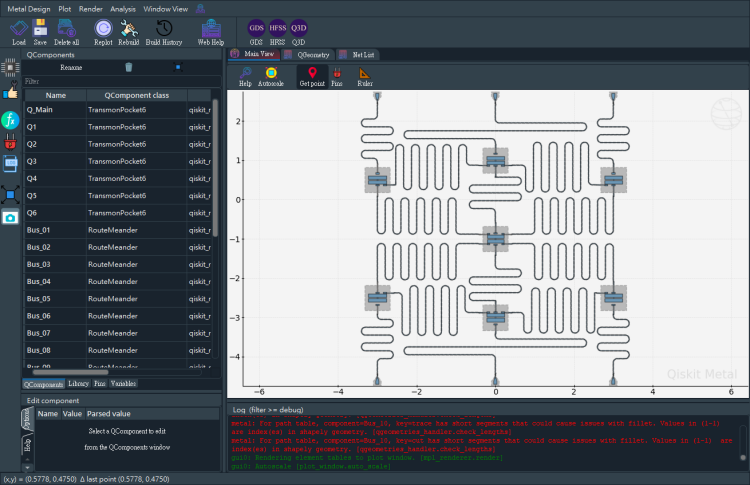

In [21]:
gui.rebuild()
gui.autoscale()
gui.screenshot()

With this, we have completed the construction of our layout. 

Now, anyone familiar with chip design might find some of the location choices to be sub-optimal, with large sections of your chip left unused, or perhaps some CPW transmission lines running a bit closer to each other than would be ideal for avoiding cross talk concerns. These could be address by shifting the origin of your chip, or modifying component options to better compact your layout and alleviate crosstalk concerns.

For this tutorial, we aren't too concerned how much space we may use up on our fictional chip, so we will instead continue on to analysis and tuning.

# Analyze
## Capacitance Extraction and LOM

First we want to quickly look at the qubit parameters. Initial simulation and analysis is to use a lumped element approximation, by extracting the capacitance matrix of the qubit. We first analyze the qubit `Q_Main`, by first extracting the matrix and then using LOM analysis on it.

For starters, let's select the appropriate QAnalysis class.

In [22]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

We can check if we wish to change any of the default options for the analysis. You should modify the number of passes and convergence based on the accuracy you require for your simulation.

Depending on the complexity of the simulation, it could take a minute, or multiple hours. It is generally best to start with a small number of `max_passes` if you are unsure, so can you get a sense on the timing. As each adaptive pass adds additional tetrahedrons, the simulation time per pass will increase significantly (as well as the amount of system memory necessary).

In [23]:
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [24]:
c1.sim.setup.name = 'Tune_Q_Main'
c1.sim.setup.max_passes = 16
c1.sim.setup.min_converged_passes = 2
c1.sim.setup.percent_error = 0.05
c1.sim.setup

{'name': 'Tune_Q_Main',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 16,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.05,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

Next we will want to run the simulation for Q_Main. To obtain the complete capacitance matrix from this simulation, we will want to terminate the unconnected pins of Q_Main with opens, so that they are regarded as isolated charge islands in the simulation. You will need to list all of the pin names in the call. To recall them, one can look at the GUI, or check the pin dictionary attached to Q_Main: `q_main.pins.keys()`.

In [25]:
c1.sim.run(name="Q_Main", components=['Q_Main'], open_terminations=[('Q_Main', 'bus_00'), ('Q_Main', 'bus_01'),('Q_Main', 'bus_02'),('Q_Main', 'bus_03'),
                                      ('Q_Main', 'bus_04'), ('Q_Main', 'bus_05')])

INFO 05:45PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:45PM [load_ansys_project]: 	Opened Ansys App
INFO 05:45PM [load_ansys_project]: 	Opened Ansys Desktop v2023.1.0
INFO 05:45PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/askev/OneDrive/文件/Ansoft/
	Project:   Project8
INFO 05:45PM [connect_design]: 	Opened active design
	Design:    QMain_Q5_Bus05_hfss [Solution type: Eigenmode]
INFO 05:45PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:45PM [connect]: 	Connected to project "Project8" and design "QMain_Q5_Bus05_hfss" 😀 

INFO 05:45PM [connect_design]: 	Opened active design
	Design:    Q_Main_q3d [Solution type: Q3D]
INFO 05:45PM [get_setup]: 	Opened setup `Tune_Q_Main`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:45PM [analyze]: Analyzing setup Tune_Q_Main
INFO 05:49PM [get_matrix]: Exporting matrix data to (C:\Users\askev\AppData\Local\Temp\tmplxj0nhpu.txt, C, , Tune_Q_Main:LastAdaptive, "Original", "ohm", "

With the simulation completed, we can look at the capacitance matrix.

In [26]:
c1.sim.capacitance_matrix

,bus_00_connector_pad_Q_Main,bus_01_connector_pad_Q_Main,bus_02_connector_pad_Q_Main,bus_03_connector_pad_Q_Main,bus_04_connector_pad_Q_Main,bus_05_connector_pad_Q_Main,ground_main_plane,pad_bot_Q_Main,pad_top_Q_Main
bus_00_connector_pad_Q_Main,44.34624,-0.72074,-0.11212,-0.16188,-0.11207,-0.72045,-31.54164,-9.04565,-1.23750
bus_01_connector_pad_Q_Main,-0.72074,40.99293,-0.24013,-0.11219,-0.04507,-0.07896,-28.99937,-9.23107,-1.06971
bus_02_connector_pad_Q_Main,-0.11212,-0.24013,40.99639,-0.72053,-0.07898,-0.04505,-29.00036,-1.06972,-9.22962
bus_03_connector_pad_Q_Main,-0.16188,-0.11219,-0.72053,44.34424,-0.72087,-0.11207,-31.54257,-1.23815,-9.04264
bus_04_connector_pad_Q_Main,-0.11207,-0.04507,-0.07898,-0.72087,40.99171,-0.24009,-28.99966,-1.06949,-9.22945
bus_05_connector_pad_Q_Main,-0.72045,-0.07896,-0.04505,-0.11207,-0.24009,40.99756,-29.00002,-9.23050,-1.06923
ground_main_plane,-31.54164,-28.99937,-29.00036,-31.54257,-28.99966,-29.00002,308.41040,-32.96663,-32.96410
pad_bot_Q_Main,-9.04565,-9.23107,-1.06972,-1.23815,-1.06949,-9.23050,-32.96663,97.17834,-31.17030
pad_top_Q_Main,-1.23750,-1.06971,-9.22962,-9.04264,-9.22945,-1.06923,-32.96410,-31.17030,97.16867


But more importantly, we can use that matrix to run LOM analysis.

In [27]:
c1.setup.junctions = Dict({'Lj': 14, 'Cj': 2})
c1.setup.freq_readout = 7.0
c1.setup.freq_bus = [5.6, 5.7, 5.8, 5.9, 6.0]  # list of the bus frequencies

c1.run_lom()
c1.lumped_oscillator_all

[6, 7] [8 0 1 2 3 4]
Predicted Values

Transmon Properties
f_Q 4.422680 [GHz]
EC 233.452954 [MHz]
EJ 11.671114 [GHz]
alpha -268.134154 [MHz]
dispersion 9.193667 [KHz]
Lq 13.994355 [nH]
Cq 82.972726 [fF]
T1 60.802647 [us]

**Coupling Properties**

tCqbus1 -16.650728 [fF]
gbus1_in_MHz -195.187665 [MHz]
χ_bus1 -2.946258 [MHz]
1/T1bus1 2407.470804 [Hz]
T1bus1 66.108774 [us]

tCqbus2 0.143024 [fF]
gbus2_in_MHz 1.363010 [MHz]
χ_bus2 -0.000596 [MHz]
1/T1bus2 0.058460 [Hz]
T1bus2 2722447.965296 [us]

tCqbus3 -0.575970 [fF]
gbus3_in_MHz -5.588801 [MHz]
χ_bus3 -0.008653 [MHz]
1/T1bus3 0.833206 [Hz]
T1bus3 191015.028584 [us]

tCqbus4 5.737932 [fF]
gbus4_in_MHz 56.611435 [MHz]
χ_bus4 -0.775239 [MHz]
1/T1bus4 73.361465 [Hz]
T1bus4 2169.462454 [us]

tCqbus5 6.183172 [fF]
gbus5_in_MHz 62.001835 [MHz]
χ_bus5 -0.819344 [MHz]
1/T1bus5 76.305867 [Hz]
T1bus5 2085.749738 [us]

tCqbus6 5.737952 [fF]
gbus6_in_MHz 58.546201 [MHz]
χ_bus6 -0.648843 [MHz]
1/T1bus6 59.536212 [Hz]
T1bus6 2673.246057 [us]
Bus-Bus C

,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,4.731766,269.625725,11.671114,-313.866511,35.099232,"[-156.22543631753442, -10.591979754233485, -2....","[-2.730253372368821, -0.06929849132632895, -0....",2.730253,156.225436
2,4.657856,260.704409,11.671114,-302.486353,25.901164,"[-165.62039331385859, -3.5202299483184754, -5....","[-2.8044302085467505, -0.006466638775429204, -...",2.804430,165.620393
3,4.580867,251.594024,11.671114,-290.93367,18.673822,"[-177.33207924496472, -0.5274383199523356, -4....","[-2.9309422751036314, -0.0001228469089146232, ...",2.930942,177.332079
4,4.535882,246.356307,11.671114,-284.323055,15.343995,"[-182.14069760984705, 0.3387489735627822, -4.5...","[-2.930874355388907, -4.612885364251967e-05, -...",2.930874,182.140698
5,4.508578,243.207927,11.671114,-280.360352,13.593295,"[-184.91758460027998, 0.33929277254929513, -4....","[-2.9248723322680723, -4.37637157335862e-05, -...",2.924872,184.917585
6,4.487009,240.73701,11.671114,-277.256067,12.339553,"[-185.86456790222888, 0.8767407247138957, -5.5...","[-2.880701414754482, -0.0002797745435096227, -...",2.880701,185.864568
7,4.475098,239.378695,11.671114,-275.55172,11.692731,"[-189.03232458438362, 0.8174435348892515, -4.8...","[-2.938276569248754, -0.00023748701435804187, ...",2.938277,189.032325
8,4.463117,238.016849,11.671114,-273.844469,11.073063,"[-189.81618081563502, 1.324114313358849, -5.43...","[-2.9213085232550835, -0.0006084706967011987, ...",2.921309,189.816181
9,4.454672,237.05963,11.671114,-272.645385,10.654229,"[-190.81251414277867, 1.3575281808087414, -5.5...","[-2.922972410276865, -0.0006289856769276232, -...",2.922972,190.812514
10,4.446755,236.164147,11.671114,-271.524316,10.274548,"[-192.49827175267976, 1.1825086858253608, -5.3...","[-2.947390953862438, -0.00046988035859885666, ...",2.947391,192.498272


Which gives us the qubits frequency, anharmonicity, and coupling strength to the different connection pads.

We can further check if these parameters converged well. If they have not, we may want to modify our simulation in order to get a more accurate result. We then will want to make modifications to our qubit options, such as `pad_gap` of the qubit, or modifying the size of the connection pads, in order to hit the desired qubit anharmonicity or readout chi values respectively.

In [28]:
c1.plot_convergence();
c1.plot_convergence_chi()

  self._hfss_variables[variation] = pd.Series(

INFO 05:49PM [hfss_report_full_convergence]: Creating report for variation 0


Design "Q_Main_q3d" info:
	# eigenmodes    0
	# variations    1


Once the analysis and tuning is complete, we can stop the analysis and the renderer.

In [29]:
c1.sim.close()

## Eigenmode and EPR

Once each of our qubits have been run through LOM, we can begin to look at the resonant busses and readouts, and larger coupled sections of the chip. One such case could be looking at Q_Main, Q5, and Bus_05. This allows us not only to look at some of the parameters of the individual qubits, but also the bus frequency and if the qubits are coupled (via the bus) to the degree we wish.

#### Preparations
We will setup the design and simulation in the same manner as we did previously, but with the methods needed for an eigenmode simulation.

In [30]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_qb = EPRanalysis(design, "hfss")

(optional) you can tune the wirebond size by directly modifying the renderer options.

In [31]:
eig_qb.sim.renderer.options['wb_size'] = 5

Review and update the simulation setup by executing following two cells.

In [32]:
em_p = eig_qb.sim.setup

In [33]:
em_p.name = '3Modes'
em_p.min_freq_ghz = 4
em_p.n_modes = 3
em_p.max_passes = 10
em_p.max_delta_f = 0.1
em_p.min_converged = 2
# Design variables can also be added in for direct simulation sweeps.
em_p.vars = Dict({'Lj1': '13 nH', 'Cj1': '0 fF', 'Lj2': '15 nH', 'Cj2': '0 fF'})

eig_qb.sim.setup

{'name': '3Modes',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 4,
 'n_modes': 3,
 'max_delta_f': 0.1,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 2,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF', 'Lj2': '15 nH', 'Cj2': '0 fF'}}

Before we execute the analysis, we want to update the design if needed. For example we may want to modify the junction inductance of the two qubits based on the previous LOM analysis, so they are near the desired frequency. Further, one may want to change the length of the bus after initial simulations to get it to the target frequency:

In [34]:
q_main.options.hfss_inductance

'14nH'

In [35]:
Q5.options.hfss_inductance

'14nH'

In [36]:
q_main.options.hfss_inductance = '14nH'
Q5.options.hfss_inductance = '14nH'
bus_06.options.total_length = '6mm'

gui.rebuild()

05:49PM 23s WARNING [check_lengths]: For path table, component=Bus_01, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:49PM 24s WARNING [check_lengths]: For path table, component=Bus_01, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:49PM 24s WARNING [check_lengths]: For path table, component=Bus_02, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:49PM 24s WARNING [check_lengths]: For path table, component=Bus_02, key=cut has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:49PM 24s WARNING [check_lengths]: For path table, component=Bus_03, key=trace has short segments that could cause issues with fillet. Values in (22-23)  are index(es) in shapely geometry.
05:49PM 24s WARNING [check_lengths]: For path tab

We can now run the simulation on the specified layout. All unconnected pins are left as shorts, as we are only concerned about simulating the resonant mode of the three components listed.

In [38]:
#eig_qb.sim.run(name="QMain_Q5_Bus05", components=['Q_Main', 'Q5','Bus_06'], open_terminations=[])

Once the simulation is complete, we can check to see if the convergence was good.

In [ ]:
eig_qb.sim.plot_convergences()

With the eigenmode simulation complete (and nicely converged) we can run some EPR analysis on the result.

At first we need to define the junctions in terms of name, inductance_variable, capacitance_variable, rectancle that was defined in the rendering to represent the junction `port` and line that was defined in the rendering to represent the direction of the current thorugh the junction.

In [40]:
eig_qb.del_junction()
eig_qb.add_junction('jj1', 'Lj1', 'Cj1', rect='JJ_rect_Lj_Q_Main_rect_jj', line='JJ_Lj_Q_Main_rect_jj_')
eig_qb.add_junction('jj2', 'Lj2', 'Cj2', rect='JJ_rect_Lj_Q5_rect_jj', line='JJ_Lj_Q5_rect_jj_')
eig_qb.setup.sweep_variable = 'Lj1'
eig_qb.setup

{'junctions': {'jj1': {'Lj_variable': 'Lj1',
   'Cj_variable': 'Cj1',
   'rect': 'JJ_rect_Lj_Q_Main_rect_jj',
   'line': 'JJ_Lj_Q_Main_rect_jj_'},
  'jj2': {'Lj_variable': 'Lj2',
   'Cj_variable': 'Cj2',
   'rect': 'JJ_rect_Lj_Q5_rect_jj',
   'line': 'JJ_Lj_Q5_rect_jj_'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj1'}

Note in the previous cell output that the dissipatives have alrady been defined by default.

Now we can start looking at the EPR values. First we look at the electric field and subtrate participation. Then extract the kerr matrix.

In [41]:
#eig_qb.run_epr()
# (pyEPR allows to switch modes: eprd.set_mode(1))

From the analysis results we can determine the qubits anharmonicities and coupling strength.
Once the analysis and tuning is complete, we can close the connection to Ansys.

In [42]:
eig_qb.sim.close()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


### Rendering to a GDS File

Once all of the tuning is complete, we will want to prepare a GDS file so we can create a mask and fabricate our chip. We first create a gds render instance.

In [43]:
full_chip_gds = design.renderers.gds

The various options for the gds renderer can also be checked and changed as necessary. A key option is the gds file which holds the cells for your junction ebeam design. Make sure this is pointing at the correct file so they are placed in your final mask at the appropriate locations.

In [44]:
full_chip_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [51]:
full_chip_gds.options['path_filename'] ='/Neko.GDS' 
#'../resources/Fake_Junctions.GDS'
full_chip_gds.options['no_cheese']['buffer']='50um'

In [53]:
full_chip_gds.export_to_gds('Neko.gds')

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df

1

(optional) With the design complete, we can close the GUI.

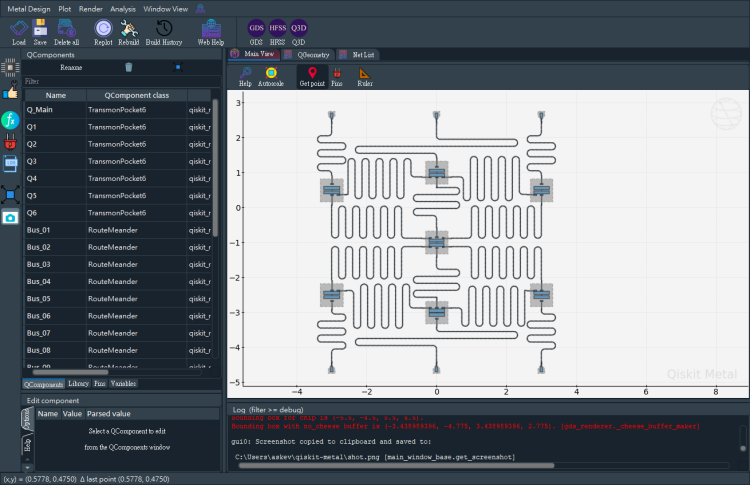

In [48]:
gui.screenshot()
gui.figure.savefig('Neko.png')

In [ ]:
# gui.main_window.close()